# Исследование надежности заемщиков.

### Шаг 1. Обзор данных

In [1]:
import pandas as pd
import seaborn as sns
data = pd.read_csv('/datasets/data.csv') #открытие файла с данными

data.info()#просмотр общей информации о датафрейме

columns = data.columns #Экспресс-анализ данных в таблице для поиска артефактов данных
for column in columns:
    print (data[column].value_counts())

    
data.duplicated().sum() #поиск наличия явных дубликатов данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64
-986.927316     1
-7026.359174    1
-4236.274243    1
-6620.396473    1
-1238.560080    1
               ..
-2849.351119    1
-5619.328204    1
-448.829898     1
-1687.038672    1
-582.538413    

54

Получили таблицу с данными и провели анализ качества данных. Видим что таблица состоит из 12 колонок с различным качеством данных, в некоторых столбцах имеются пропуски данных. В начальном виде таблица имеет **54** явных дубликата.  

В столбце `children` имеется явные артефакты: 47 раз ввели количество детей -1, чего быть не может, а так же 76 раз ввели значение 20, что тоже является сомнительными данными. Предполагаю, что эти артефакты в данных данной строки связаны с человеческим фактором при заполнении форм сотрудниками, откуда эти данные тянутся.  

Столбец `days_employed` содержит 19351 уникальных, но, увы, бесполезных для нашего исследования данных. Во-первых, в столбце содержатся как положительные, так и отрицательные(!) значения. И если отбросить гипотезу, что отрицательные значения — это количества дней в загробной жизни, которые человек отрабатывает выданный кредит, то наличие таких значений, как 400281 дней трудового стажа (или 1096 лет) говорит нам, что данные в таком виде не пригодны для анализа. Во-вторых, имеются пропуски в данных (NaN). Согласно условиям задания, нам не требуется знать количество дней стажа для анализа, поэтому со столбцом `days_employed` можно смело прощаться, удалив его.  

Столбец `education` содержит данные об образовании клиентов, но они записаны с применением разных регистров. Приведем к единому знаменателю, преобразовав данные в строчный формат. После преобразования количество повторений значений `education` совпадет с количеством повторений значения `education_id`. В дальнейшем данные могут при необходимости лечь в словарь категорий.

Столбцы `education_id` и `family_status_id` содержат корректные значения, дополняющие друг друга. Их можно будет легко сгруппировать в отдельный словарь категорий для упрощения датафрейма.  

В столбце `gender` имеется 1 артефакт — значение **"XNA"**. Возможно, это ошибка сотрудника, заполнявшего данные в анкете, возможно это дань современных тенденциям в отказе от биполярных гендеров. Не думаю, что данное значение способно повлиять на дальнейший анализ, оставим его. 

К столбцу `debt` нет вопросов о качестве данных. 

В столбце `total_income` у данных имеется две проблемы. Во-первых, пропуски, в таком объеме, что мы не можем их удалить, так как сильно исказится исходный сет данных **(2174 пропуска или почти 11% данных)**. Во-вторых, большое количество чисел после запятой, такого быть не может. Будем далее исправлять данные проблемы. Замену пропущенных значений будем производить на медианные значения, найденные по  аналогичной группе заемщиков. **Использование медианного значения дохода, найденной по группе заемщиков - наиболее точный способ заполнить пропуски в данных о доходе, так как она будет наиболее точно интерпретировать "среднее" значение в группе заемщиков, учтя возможный разброс в доходах. 

В столбце `purpose` одинаковые данные записаны с помощью разных слов ("Образование", "получение образования", "получение дополнитьного образования"). С помощью лемматизации можно будет составить топ целей получения кредита.


### Шаг 2.1 Заполнение пропусков

In [2]:
data['education'] = data['education'].str.lower() #приведение значений столбца к строчной записи
#заполнение пропусков исходя из группировки данных по типу заемщиков и их уровне образования
data_transformed = data.groupby(['income_type', 'education'])['total_income'].transform('median') 
data['total_income'] = data['total_income'].fillna(data_transformed)
data.info() #проверка данных о результате операций, пропуски заполненны


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Шаг 2.2 Проверка данных на аномалии и исправления.

In [3]:
data = data.drop(columns ='days_employed',axis=1) #удаление ненужного столбца
data ['children'] = data['children'].replace([20, -1], [2, 1]) #замена ошибочно введенных значений в столбце с количесвом детей


### Шаг 2.3. Изменение типов данных.

In [4]:
data ['total_income'] = data['total_income'].astype('int') 
# присвоение столбцу total_income типа данных integer для устранения ненужных чисел после запятой 


### Шаг 2.4. Удаление дубликатов.

In [5]:
print(data.duplicated().sum()) 
#Пересчет явных дубликатов после приведения столбца  'education' к строчной записи и обработки данных от  неявных дубликатов 
#и избавления от чисел после запятой в столбце 'total_income' 
data = data.drop_duplicates().reset_index(drop=True)
data.info() # проверка результата, дубликаты устранены

71
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 11 columns):
children            21454 non-null int64
dob_years           21454 non-null int64
education           21454 non-null object
education_id        21454 non-null int64
family_status       21454 non-null object
family_status_id    21454 non-null int64
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null int64
total_income        21454 non-null int64
purpose             21454 non-null object
dtypes: int64(6), object(5)
memory usage: 1.8+ MB


Удаление дубликатов произведено по схеме — обнаружение явных дубликатов — исправление данных для выявления неявных дубликатов — удаление дубликатов с помощью специальной функции Pandas. Этот способ позволяет получить на выходе "чистые" данные без всякого "шума" и приступить к дальнейшему их анализу.  

Причиной появления данных дубликатов является человеческий фактор и несовершенность системы, с помощью которой производится анкетирование или создание анкеты заёмщика.  Система не проверяет ввод данных за пользователем при первоначально их вводе, явно отсутствует выбор данных при вводе из заранее использованных пресетов (о чем свидетельствует разные формы записи данных об образовании) и позволяет человеку ввести данные используя разный регистр. Так же при вводе данных происходят опечатки, т.е. возникает человеческий фактор.

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [6]:
education_dict = data [['education', 'education_id']] #формирование словаря с данными об образовании, удаление дубликатов строк в словаре
education_dict = education_dict.drop_duplicates().reset_index(drop=True)


family_status_dict = data [['family_status', 'family_status_id']] #формирование словаря с данными о статусе семьи, удаление дубликатов строк в словаре
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)

data = data.drop(columns = ['family_status', 'education'],axis=1) #декомпозиция исхоного датасета

display(family_status_dict)
display(education_dict)

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


### Шаг 2.6. Категоризация дохода.

In [7]:
#написание функции по категоризации дохода и вывод результатов о категорий на экран
def income_grouped (income):
    if income <= 30000:
        return 'E'
    if income >= 30001 and income <=50000:
        return 'D'
    if income >= 50001 and income <= 200000:
        return 'C'
    if income >=200001 and income <=1000000:
        return 'B'
    return 'A'

data['total_income_category'] = data['total_income'].apply(income_grouped)
data['total_income_category'].value_counts()

C    15829
B     5228
D      350
A       25
E       22
Name: total_income_category, dtype: int64

In [8]:
#написание функции по категризации данных о целей кредита с примением Лемматизации для сортировки данных  

from pymystem3 import Mystem
m = Mystem() 
data['lemmas'] = data['purpose'].apply(m.lemmatize)
def purpose_grouped(lemmas):
    
    if 'образование' in lemmas:
        return 'получение образования'
    if 'свадьба' in lemmas:
        return 'проведение свадьбы'
    if 'автомобиль' in lemmas:
        return 'операции с автомобилем'
    if 'жилье' in lemmas or 'недвижимость' in lemmas:
        return 'операции с недвижимостью'
    return 'опять косяк'

data['purpose_category'] = data['lemmas'].apply(purpose_grouped)
data = data.drop(columns = 'lemmas', axis = 1)

data.head(10) #вывод 10 первых индексов итогового варианта датасета для визуального контроля дататсета 


,children,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,42,0,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,33,1,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,32,1,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы
5,0,27,0,1,M,компаньон,0,255763,покупка жилья,B,операции с недвижимостью
6,0,43,0,0,F,компаньон,0,240525,операции с жильем,B,операции с недвижимостью
7,0,50,1,0,M,сотрудник,0,135823,образование,C,получение образования
8,2,35,0,1,F,сотрудник,0,95856,на проведение свадьбы,C,проведение свадьбы
9,0,41,1,0,M,сотрудник,0,144425,покупка жилья для семьи,C,операции с недвижимостью


### Ответы на вопросы.

##### Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [9]:
def data_clildren_group (children):
    if children == 0:
        return 'без детей'
    return 'c детьми'

data['children_group'] = data['children'].apply(data_clildren_group)
data_pivot_children_group = data.pivot_table(index = ['children_group'], columns = 'debt', values = 'children', aggfunc = 'count')
data_pivot_children_group['debt_percentage'] = data_pivot_children_group[1]/(data_pivot_children_group [0] + data_pivot_children_group [1])*100
data_pivot_children_group


debt,0,1,debt_percentage
children_group,,,
c детьми,6685,678,9.208203
без детей,13028,1063,7.543822


In [10]:
data_pivot_children = data.pivot_table(index = ['children'], columns = 'debt', values = 'total_income', aggfunc = 'count')
data_pivot_children['debt_percentage'] = data_pivot_children[1]/(data_pivot_children [0] + data_pivot_children [1])*100
data_pivot_children


debt,0,1,debt_percentage
children,,,
0,13028.0,1063.0,7.543822
1,4410.0,445.0,9.165808
2,1926.0,202.0,9.492481
3,303.0,27.0,8.181818
4,37.0,4.0,9.756098
5,9.0,NaN,NaN


**Вывод:** Из 2-х сводных таблиц видно, что заемщики с детьми чаще на 1,7% имеют вероятность несвоевременных платежей по кредитам.  При этом анализ по количеству детей не показал сильной закономерности в своевременности возврата заемных средств от количества детей. 

Статистически, чаще всего несвоевременно возвращали кредиты заёмщики с 4-мя детьми (9,75% от зафиксированных случаев не возвратов), далее следуют заемщики с 2-мя детьми (202 случая или 9,49% от случаев просрочки), на третьем месте идут родители 1-го ребенка (9,16%). Реже всего возникают проблемы с возвратом кредитов у родителей 3-х детей (8,18%), а так же у родителей 5-рых детей (на 9 наблюдений не было зафиксировано ни одной проблемы с возвратом заемных средств, но следует отметить что выборка не достаточна для полной оценки данного параметра).

##### Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [11]:
data_pivot_family= data.pivot_table(index = ['family_status_id'], columns = 'debt', values = 'total_income', aggfunc = 'count')
data_pivot_family['debt_percentage'] = data_pivot_family[1]/(data_pivot_family [0] + data_pivot_family [1])*100
data_pivot_family = data_pivot_family.merge(family_status_dict, on = 'family_status_id', how = 'right') #объединение с таблицей-справочником family_status_dict для более удобного анализа 
data_pivot_family

,family_status_id,0,1,debt_percentage,family_status
0,0,11408,931,7.545182,женат / замужем
1,1,3763,388,9.347145,гражданский брак
2,2,896,63,6.569343,вдовец / вдова
3,3,1110,85,7.112971,в разводе
4,4,2536,274,9.750890,Не женат / не замужем


**Вывод:** Из данных анализа видно, что самые надежные заемщики — вдовцы или вдовы — среди данной группы всего лишь  6,6% случаев просрочек по платежам. Далее следуют заемщики в разводе и женатые/замужние (7,1% и 7,5% соответственно). Хуже всего с возвратом заемных средств у людей, находящихся в гражданском браке и не женатых и не замужних, среди них вероятность неплатежей составляет более 9,3% и 9,75% соответственно.

##### Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [12]:
data_pivot_income= data.pivot_table(index = ['total_income_category'], columns = 'debt', values = 'total_income', aggfunc = 'count')
data_pivot_income['debt_percentage'] = data_pivot_income[1]/(data_pivot_income [0] + data_pivot_income [1])*100
data_pivot_income

debt,0,1,debt_percentage
total_income_category,,,
A,23,2,8.000000
B,4864,364,6.962510
C,14477,1352,8.541285
D,329,21,6.000000
E,20,2,9.090909


**Вывод:** Самые надежные заемщики —  люди с доходом от 30001 до 50000 и 200 001 до 1 000 000. Среди данных групп вероятность неплатежей варьируется от 6 до почти 7%%. Самые ненадежные заемщики — люди с доходом до 30000, вероятность несвоевременных платежей в данной группе составляет 9,09%.
Удивительно, что самая массовая группа заемщиков - с доходом от 50 до 200 тысяч — так же оказалась в группе риска по несвоевременным платежам по кредитам - 8,5% от числа выданных кредитов имели проблемы с возвратом.

##### Вопрос 4: Как разные цели кредита влияют на его возврат в срок?

In [13]:
data_pivot_purpose= data.pivot_table(index = ['purpose_category'], columns = 'debt', values = 'total_income', aggfunc = 'count')
data_pivot_purpose['debt_percentage'] = data_pivot_purpose[1]/(data_pivot_purpose [0] + data_pivot_purpose [1])*100
data_pivot_purpose


debt,0,1,debt_percentage
purpose_category,,,
операции с автомобилем,3903,403,9.359034
операции с недвижимостью,10029,782,7.233373
получение образования,3643,370,9.220035
проведение свадьбы,2138,186,8.003442


**Вывод:** Самые надежные заемщики - люди, взявшие кредит на операции с недвижимостью. Оно и понятно, жить/вести бизнесс где-то нужно =). Всего 7,2% проблемных займов. 
Хуже всего платили за кредиты, взятые для операций с автомобилем и получение образования - более 9% займов выданных на эти цели испытывали трудности с возвратом.

## Общий вывод:

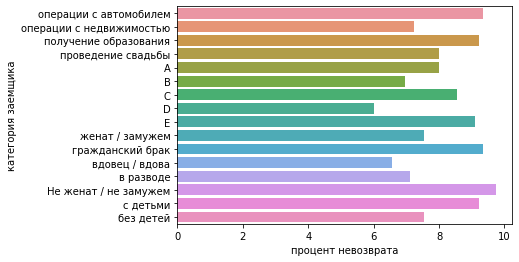

In [14]:
# для визуализации построем датафрем со всеми полученными результами и постоим по ним гистограмму
debt_percentage = pd.DataFrame([['операции с автомобилем', 9.35903],
                  ['операции с недвижимостью', 7.233373],
                  ['получение образования', 9.220035],
                  ['проведение свадьбы', 8.003442],
                  ['A', 8.000000],
                   ['B', 6.962510],
                   ['C', 8.541285],
                   ['D', 6.000000],
                   ['E', 9.090909],
                   ['женат / замужем', 7.545182],
                   ['гражданский брак', 9.347145],
                   ['вдовец / вдова' , 6.569343],
                   ['в разводе', 7.112971],
                   ['Не женат / не замужем', 9.750890],
                   ['c детьми', 9.208203],
                   ['без детей', 7.543822]],
                 columns=['категория заемщика', 'процент невозврата'])
sns.barplot(
    y="категория заемщика", 
    x="процент невозврата",  
    data=debt_percentage)

 **Вывод:** Полученные результаты позволяют в дальнейшем провести более глубокий факторный анализ влияния каждого фактора на негативный вариант возврата заемных средств, построить математическую модель, расчесывающую вероятность не возврата по кредиту и т.д. 
Полученные данные по каждой группе говорят нам, что самыми беспроблемными являются заемщики в статусе вдова или вдовец, не имеющие детей, с доходом от 30 до 50 тысяч, берущие займ на операции с недвижимостью.
А так же можно выдвинуть гипотезу, что самый проблемный заемщик — это человек с детьми, берущий кредит на проведение операции с автомобилем, обладающий доходом до 30 тысяч и при этом не состоящий в браке.